In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import statsmodels.api as sm
#import multiprocessing as mp
import matplotlib.pyplot as plt
from __future__ import division
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
strips = pd.read_excel('./HW1_data.xls')
strips.columns = ['Mat', 'Px']

In [3]:
def spot_rate(t, P, APR=True):
    
    r = (100 / P) ** (1 / t) - 1
    if APR: #else: EAR
        r = 2 * ((1 + r) ** 0.5 - 1)
    return r

def par_yield(T, DF):
    
    # semiannually compounded  
    t = np.linspace(0.5, T, int(2*T))
    
    return 2 * (1 - DF(T)) / np.sum(DF(t))

def fw_rate(t, dt, DF):
    
    return ((DF(t) / DF(t + dt)) - 1 ) * (1/dt)

def coupon_bond_P(c, T, DF):
    
    return (sum([c / 2 * DF(t) for t in np.linspace(0.5, T, int(2 * T))]) + DF(T)) * 100

def coupon_bond_YTM(c, T, DF):
    P = coupon_bond_P(c, T, DF) / 100
    ytm = lambda y: sum([c / 2 * (1 + y / 2) ** (-i) for i in range(1, int(2 * T))]) + (1 + c/2) * (1 + y / 2) ** (-2 * T) - P

    return opt.fsolve(ytm, c)

## Polynomial-based Yield Curve

In [4]:
lnZ = np.log(strips.Px / 100)
X = pd.concat([strips.Mat**i for i in range(1,6)], axis=1)
X.columns = ['pwr_' + str(i) for i in range(1,6)]

model = sm.OLS(lnZ, X)
poly_res = model.fit()

p = np.polynomial.Polynomial(np.r_[0, poly_res.params.values])
poly_DF = lambda t: np.exp(p(t))

ts = np.linspace(1, 30, 30)

In [5]:
def Convexity(c, T, DF, k=2):
    
    y, P = coupon_bond_YTM(c, T, DF), coupon_bond_P(c, T, DF) / 100
    C = sum([(i * i + i) / (k * k) * (c / k) * (1 + y / k) ** (-i) for i in range(1, int(k * T) + 1)])
    C += 0.5 * (2 * T * T + T) * (1 + y / k) ** (-2 * T)
    return float(C / (P * (1 + y / k)**2))

def Mac_Duration(c, T, DF, k=2):
    
    y, P = coupon_bond_YTM(c, T, DF), coupon_bond_P(c, T, DF) / 100
    d = sum([i / k *(c / k) * (1 + y / k) ** (-i) for i in range(1, int(k * T) + 1)]) + \
    T * (1 + y / k) ** (-k * T)

    return float(d / P)

## Par Bonds: 1 - 30 years

In [6]:
y_par = [par_yield(t, poly_DF) for t in ts]
mac_D_par = [Mac_Duration(par, t, poly_DF) for t, par in zip(ts, y_par)]
mod_D_par = [D / (1 + par / 2) for D, par in zip(mac_D_par, y_par)]

DV01 = [D / 100 for D in mod_D_par]
Cvx_par = [Convexity(par, t, poly_DF) for t, par in zip(ts, y_par)]

par_bonds = pd.DataFrame({'Mac Duration': mac_D_par,
                          'Mod Duration': mod_D_par,
                          'DV01': DV01,
                          'Convexity': Cvx_par},
                         index=range(1, 31))
par_bonds = par_bonds[['Mac Duration', 'Mod Duration', 'DV01', 'Convexity']]
par_bonds.round(4).to_excel('ps2_1.xlsx')
par_bonds

,Mac Duration,Mod Duration,DV01,Convexity
1,0.991645,0.975075,0.009751,1.434134
2,1.948843,1.915226,0.019152,4.664538
3,2.869727,2.818686,0.028187,9.545049
4,3.752819,3.684101,0.036841,15.924105
5,4.597136,4.510622,0.045106,23.648295
6,5.402231,5.297946,0.052979,32.566089
7,6.168206,6.046312,0.060463,42.531389
8,6.895685,6.756473,0.067565,53.406628
9,7.585761,7.429637,0.074296,65.065214
10,8.239926,8.067395,0.080674,77.393241


In [7]:
100 * (par_bonds.ix[10,'DV01'] - par_bonds.ix[15,'DV01']) / (par_bonds.ix[5,'DV01'] - par_bonds.ix[15,'DV01'])

100 - 43.4229

56.5771

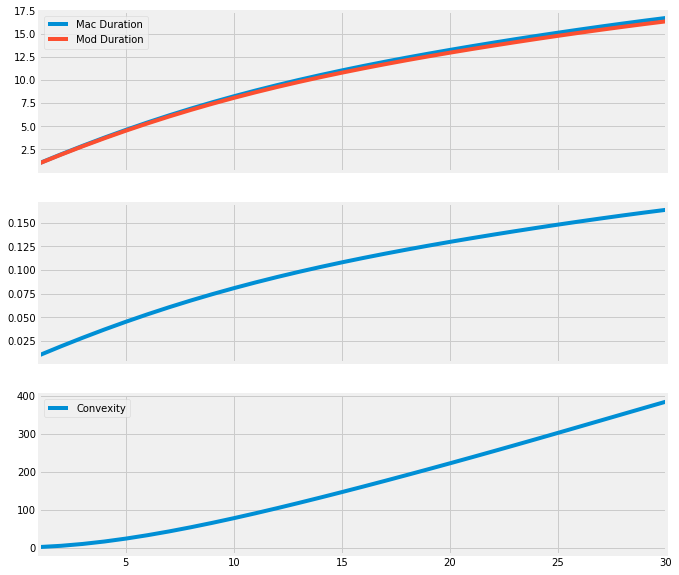

In [8]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10, 10))

par_bonds[['Mac Duration', 'Mod Duration']].plot(ax=ax[0])
par_bonds['DV01'].plot(ax=ax[1])
par_bonds['Convexity'].plot(ax=ax[2])

plt.legend()

## Coupon Bonds: 2% & 12%, 1 - 30 years

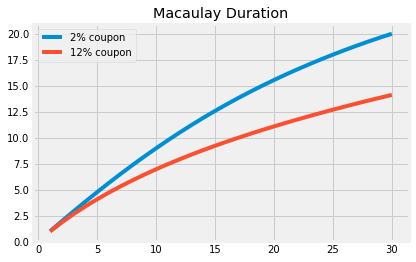

In [9]:
mac_D_2 = [Mac_Duration(0.02, t, poly_DF) for t in ts]
mac_D_12 = [Mac_Duration(0.12, t, poly_DF) for t in ts]

plt.plot(ts, mac_D_2, label='2% coupon')
plt.plot(ts, mac_D_12, label='12% coupon')
plt.title('Macaulay Duration')
plt.legend()

out = pd.DataFrame({'2%': mac_D_2, '12%': mac_D_12}, index=range(1, 31)).round(4)
out.to_excel('ps2_2.xlsx')

## Price Change: Duration approximation

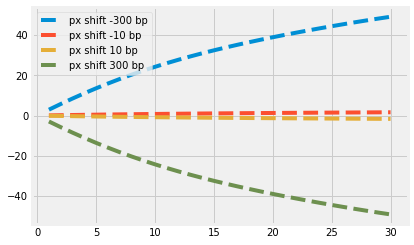

In [10]:
bps_shift = [-300, -10, 10, 300]
ts = np.linspace(1, 30, 30)

Duration_appox_ = {bps: [-D * 100 * bps / 10000 for D in mod_D_par] for bps in bps_shift}

for s in bps_shift:
    plt.plot(ts, Duration_appox_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Price Change: Convexity approximation

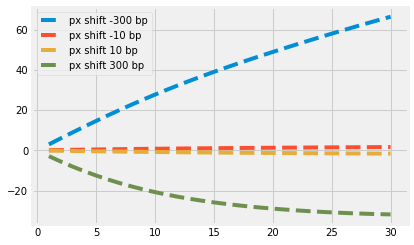

In [11]:
Convexity_appox_ = {bps: [(-D * bps / 10000 + 0.5 * C * (bps / 10000) ** 2) * 100 for C, D in zip(Cvx_par, mod_D_par)] \
                    for bps in bps_shift}

for s in bps_shift:
    plt.plot(ts, Convexity_appox_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Exact Price Change

In [12]:
def DF_parallel_shift(DF, shift, k=2):
    
    def shifted_DF(t): 
        spot = spot_rate(t, DF(t)*100)
        return (1 + (spot + shift) / k) ** (-t * k)
    
    return shifted_DF

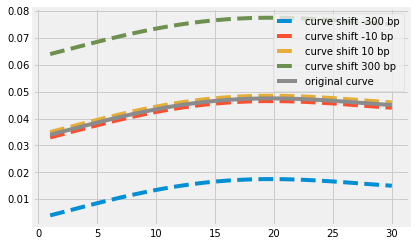

In [13]:
spot_curve = spot_rate(ts, poly_DF(ts)*100)
shifted_DF = {bps: DF_parallel_shift(poly_DF, bps / 10000) for bps in bps_shift}

spot_curve_ = {bps: spot_rate(ts, shifted_DF[bps](ts)*100) for bps in shifted_DF.keys()}

for s in bps_shift:
    plt.plot(ts, spot_curve_[s], ls='--', label='curve shift %.f bp'%s)

plt.plot(ts, spot_curve, label='original curve')
plt.legend()

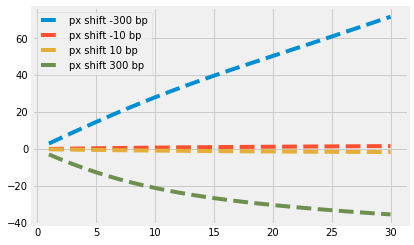

In [14]:
#par_price = [coupon_bond_P(y, t, poly_DF) for y, t in zip(y_par, ts)]
par_dp_ = {bps: [coupon_bond_P(y, t, shifted_DF[bps]) - 100 for y, t in zip(y_par, ts)]for bps in shifted_DF.keys()}

for s in bps_shift:
    plt.plot(ts, par_dp_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Comparison

In [15]:
data_dict = {}
for bps in bps_shift:
    data_dict[(bps, 'Duration')] = Duration_appox_[bps]
    data_dict[(bps, 'Convexity')] = Convexity_appox_[bps]
    data_dict[(bps, 'Exact')] = par_dp_[bps]

new_col = pd.MultiIndex.from_tuples(
    [(b, label) for b in bps_shift for label in ['Duration', 'Convexity', 'Exact']])
px_change = pd.DataFrame(data_dict, columns=new_col, index=range(1, 31))
px_change.round(4).to_excel('ps2_8.xlsx')
px_change

-300                            -10                            10   \
     Duration  Convexity      Exact  Duration Convexity     Exact  Duration   
1    2.925225   2.989761   2.991045  0.097507  0.097579  0.097579 -0.097507   
2    5.745679   5.955583   5.961761  0.191523  0.191756  0.191752 -0.191523   
3    8.456057   8.885584   8.902110  0.281869  0.282346  0.282322 -0.281869   
4   11.052302  11.768886  11.802545  0.368410  0.369206  0.369130 -0.368410   
5   13.531867  14.596040  14.654431  0.451062  0.452245  0.452058 -0.451062   
6   15.893838  17.359312  17.450402  0.529795  0.531423  0.531040 -0.529795   
7   18.138935  20.052848  20.184608  0.604631  0.606758  0.606066 -0.604631   
8   20.269418  22.672716  22.852889  0.675647  0.678318  0.677176 -0.675647   
9   22.288910  25.216845  25.452851  0.742964  0.746217  0.744463 -0.742964   
10  24.202185  27.684881  27.983867  0.806739  0.810609  0.808067 -0.806739   
11  26.014914  30.077985  30.447010  0.867164  0.871678  0.868168 -0.867164   
12  27.733421  32.398598  32.844927  0.924447  0.929631  0.924978 -0.924447   
13  29.364436  34.650179  35.181670  0.978815  0.984688  0.978734 -0.978815   
14  30.914875  36.836955  37.462496  1.030496  1.037076  1.029692 -1.030496   
15  32.391648  38.963670  39.693647  1.079722  1.087024  1.078116 -1.079722   
16  33.801488  41.035361  41.882111  1.126716  1.134754  1.124273 -1.126716   
17  35.150825  43.057156  44.035390  1.171694  1.180479  1.168427 -1.171694   
18  36.445672  45.034091  46.161255  1.214856  1.224398  1.210833 -1.214856   
19  37.691541  46.970951  48.267504  1.256385  1.266695  1.251729 -1.256385   
20  38.893378  48.872133  50.361717  1.296446  1.307533  1.291335 -1.296446   
21  40.055509  50.741511  52.451009  1.335184  1.347057  1.329844 -1.335184   
22  41.181590  52.582321  54.541761  1.372720  1.385387  1.367425 -1.372720   
23  42.274566  54.397036  56.639337  1.409152  1.422622  1.404213 -1.409152   
24  43.336631  56.187243  58.747777  1.444554  1.458833  1.440305 -1.444554   
25  44.369173  57.953516  60.869446  1.478972  1.494066  1.475761 -1.478972   
26  45.372732  59.695272  63.004651  1.512424  1.528338  1.510593 -1.512424   
27  46.346946  61.410632  65.151209  1.544898  1.561636  1.544768 -1.544898   
28  47.290494  63.096270  67.303979  1.576350  1.593912  1.578196 -1.576350   
29  48.201063  64.747277  69.454364  1.606702  1.625087  1.610729 -1.606702   
30  49.075312  66.357048  71.589805  1.635844  1.655046  1.642159 -1.635844   

                              300                        
   Convexity     Exact   Duration  Convexity      Exact  
1  -0.097436 -0.097436  -2.925225  -2.860689  -2.861927  
2  -0.191289 -0.191285  -5.745679  -5.535775  -5.541652  
3  -0.281391 -0.281368  -8.456057  -8.026530  -8.042072  
4  -0.367614 -0.367538 -11.052302 -10.335717 -10.367059  
5  -0.449880 -0.449695 -13.531867 -12.467693 -12.521631  
6  -0.528166 -0.527788 -15.893838 -14.428364 -14.511998  
7  -0.602505 -0.601820 -18.138935 -16.225023 -16.345508  
8  -0.672977 -0.671849 -20.269418 -17.866120 -18.030527  
9  -0.739710 -0.737980 -22.288910 -19.360976 -19.576251  
10 -0.802870 -0.800366 -24.202185 -20.719489 -20.992501  
11 -0.862649 -0.859195 -26.014914 -21.951843 -22.289495  
12 -0.919264 -0.914691 -27.733421 -23.068244 -23.477623  
13 -0.972941 -0.967098 -29.364436 -24.078693 -24.567236  
14 -1.023916 -1.016676 -30.914875 -24.992796 -25.568457  
15 -1.072419 -1.063695 -32.391648 -25.819625 -26.491012  
16 -1.118679 -1.108426 -33.801488 -26.567614 -27.344098  
17 -1.162909 -1.151134 -35.150825 -27.244493 -28.136274  
18 -1.205313 -1.192072 -36.445672 -27.857252 -28.875376  
19 -1.246074 -1.231481 -37.691541 -28.412130 -29.568461  
20 -1.285358 -1.269578 -38.893378 -28.914624 -30.221763  
21 -1.323310 -1.306558 -40.055509 -29.369507 -30.840670  
22 -1.360052 -1.342585 -41.181590 -29.780858 -31.429702  
23 -1.395683 -1.377793 -42.274566 -30.152097 -31.992503  
24 -1.430276 -1.412282 -43.336

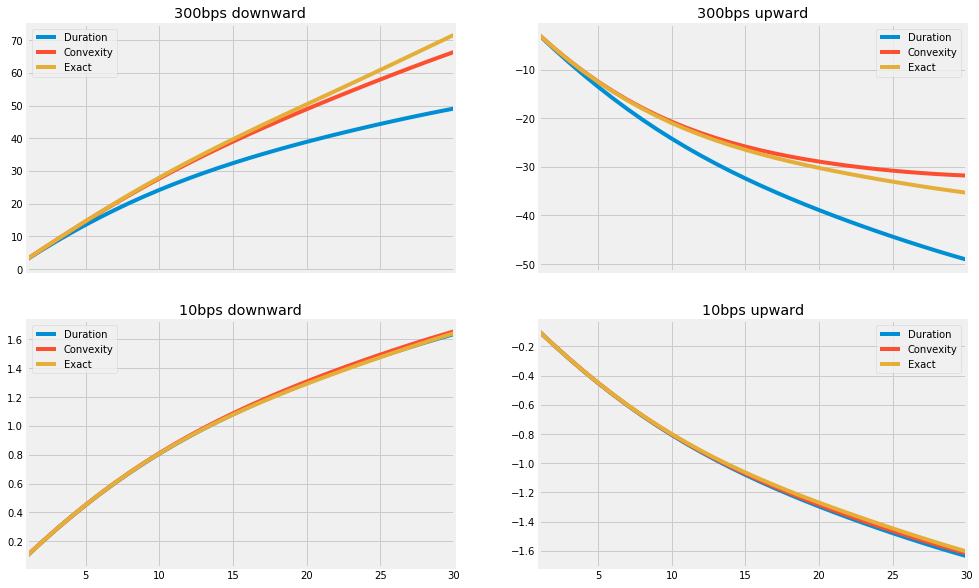

In [16]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(15, 10))
px_change[-300].plot(ax=ax[0][0])
px_change[300].plot(ax=ax[0][1])
px_change[-10].plot(ax=ax[1][0])
px_change[10].plot(ax=ax[1][1])

ax[0][0].set_title('300bps downward')
ax[0][1].set_title('300bps upward')
ax[1][0].set_title('10bps downward')
ax[1][1].set_title('10bps upward')